## Competition Description

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

n this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
import string
import time
import xgboost

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from scipy.sparse import hstack

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

%matplotlib inline

plt.style.use('ggplot')

stopwords = set(stopwords.words('english'))
stopwords = set(list(stopwords) + ['http', 'https', 's', 'nt', 'm'])

In [2]:
train_df = pd.read_csv('./data/train.csv')
print('Training rows:  {:,}'.format(len(train_df)))

train_df.head(5)

Training rows:  7,613


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
test_df = pd.read_csv('./data/test.csv')

print('Testing rows:  {:,}'.format(len(test_df)))

test_df.head(5)

Testing rows:  3,263


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Let's explore the data.

C:\Users\Craig\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


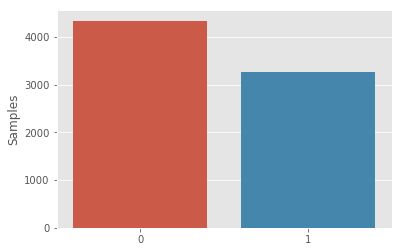

In [4]:
x = train_df['target'].value_counts()

sns.barplot(x.index, x)

plt.gca().set_ylabel('Samples')

In [5]:
def plot_hist_classes(to_plot, header):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))
  
    ax1.hist(to_plot(1), color='red')
    ax1.set_title('Disaster Tweets')
    
    ax2.hist(to_plot(0), color='green')
    ax2.set_title('Non-Disaster Tweets')
    
    fig.suptitle(header)
    plt.show()

In [6]:
def to_plot(target):
    return train_df[train_df['target'] == target]['text'].str.len()

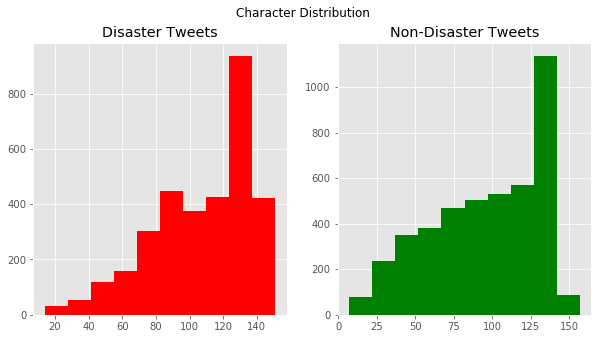

In [7]:
plot_hist_classes(to_plot, header='Character Distribution')

In [8]:
def to_plot(target):
    return train_df[train_df['target'] == target]['text'].str.split().map(lambda x: len(x))

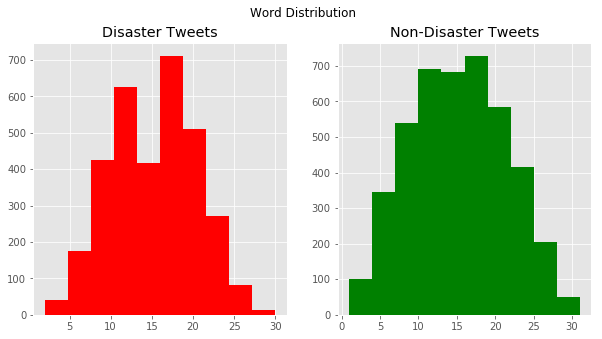

In [9]:
plot_hist_classes(to_plot, header='Word Distribution')

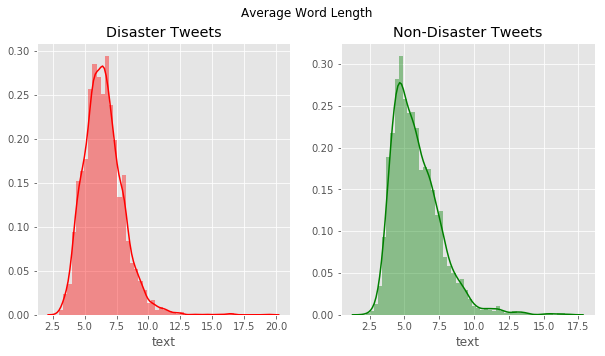

In [10]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))

words = train_df[train_df['target'] == 1]['text'].str.split().apply(lambda x : [len(i) for i in x])

sns.distplot(words.map(lambda x: np.mean(x)), ax=ax1, color='red')
ax1.set_title('Disaster Tweets')

words = train_df[train_df['target'] == 0]['text'].str.split().apply(lambda x : [len(i) for i in x])

sns.distplot(words.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Non-Disaster Tweets')

fig.suptitle('Average Word Length')

In [11]:
def show_word_distrib(target=1, field='text', rotate_xticks=False):
    text = train_df[train_df['target'] == target][field].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
    
    words = nltk.tokenize.word_tokenize(text)
    words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 
    
    top_words_df = pd.DataFrame(words_except_stop_dist.most_common(top_N), columns=['Word', 'Frequency']).set_index('Word')

    sns.set(rc={'figure.figsize': (12, 8)})

    top_words_df.plot.bar(rot=0)
    
    if rotate_xticks:
        plt.xticks(rotation=90)
        
    return top_words_df

,Frequency
Word,
:,3676
#,1703
.,1085
@,905
?,762
...,637
-,397
!,330
',295


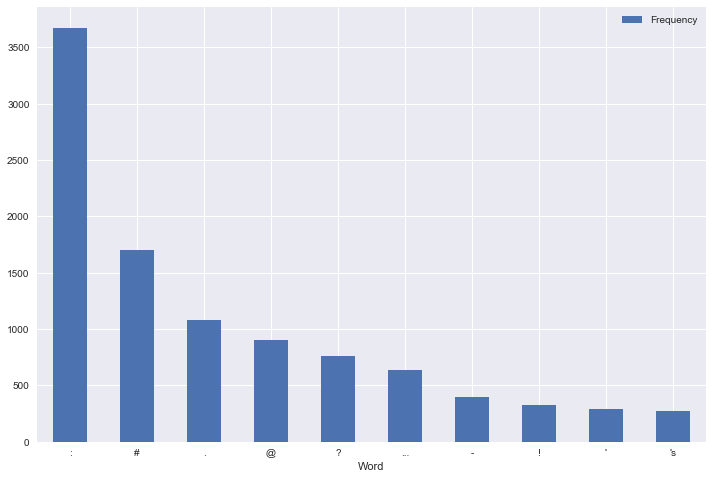

In [12]:
top_N = 10

show_word_distrib(target=1, field='text')

,Frequency
Word,
:,3030
?,2364
.,1882
@,1854
#,1700
!,843
's,515
...,426
',400


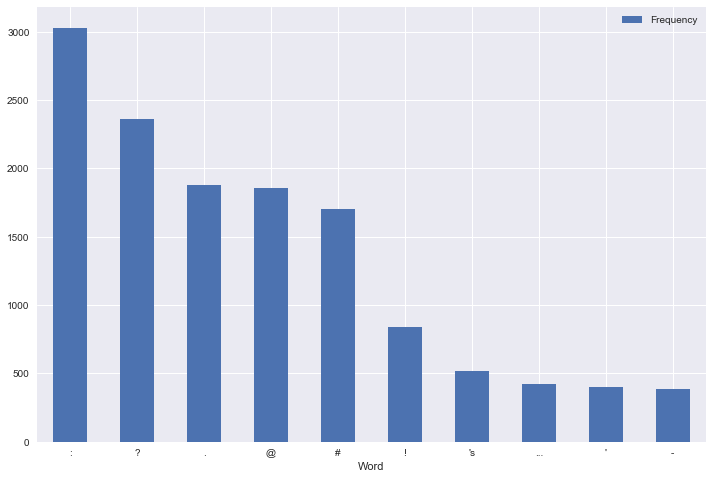

In [13]:
show_word_distrib(target=0, field='text')

In [14]:
def find_hashtags(tweet):
    return ', '.join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or None

In [15]:
def add_hashtags(df):
    df['hashtag'] = df['text'].apply(lambda x: find_hashtags(x)).fillna(value='no')
    return df

,Frequency
Word,
",",784
news,56
hiroshima,22
earthquake,19
hot,13
prebreak,13
best,13
japan,11
india,10


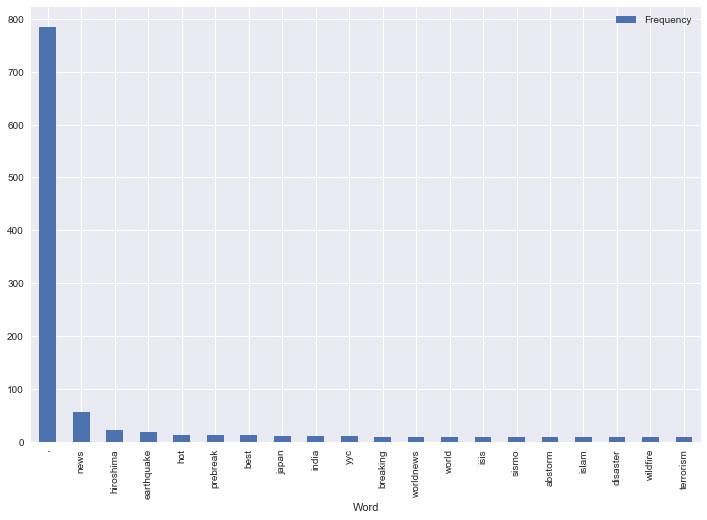

In [16]:
top_N = 20

train_df = add_hashtags(train_df)

ht_disaster_df = show_word_distrib(target=1, field='hashtag', rotate_xticks=True)
ht_disaster_df

,Frequency
Word,
",",803
nowplaying,21
news,20
hot,18
prebreak,17
best,17
gbbo,14
jobs,14
islam,14


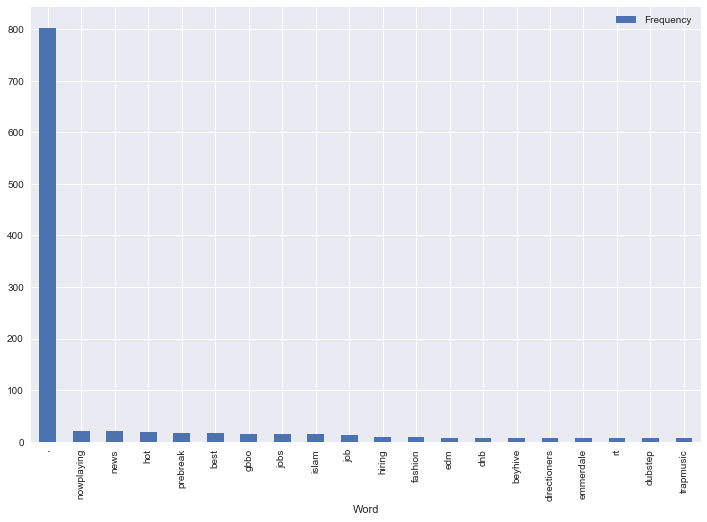

In [17]:
ht_nondisaster_df = show_word_distrib(target=0, field='hashtag', rotate_xticks=True)
ht_nondisaster_df

In [18]:
set(ht_nondisaster_df.index).intersection(ht_disaster_df.index) 

{',', 'best', 'hot', 'islam', 'news', 'prebreak'}

So there is some intersection between the hashtags of positive and disaster tweets.

%20 (HTML space encoded character) seems to be common.  Let's replace it.

In [19]:
train_df['keyword'] = train_df['keyword'].fillna('').astype(str)

train_df[train_df['keyword'].str.contains('%')]['keyword'].value_counts()

body%20bags              41
oil%20spill              38
burning%20buildings      37
dust%20storm             36
nuclear%20reactor        36
cliff%20fall             36
suicide%20bomb           35
emergency%20plan         35
bridge%20collapse        35
airplane%20accident      35
structural%20failure     35
buildings%20burning      35
heat%20wave              34
nuclear%20disaster       34
natural%20disaster       34
loud%20bang              34
buildings%20on%20fire    33
mass%20murder            33
chemical%20emergency     33
body%20bagging           33
blew%20up                33
blown%20up               33
violent%20storm          33
emergency%20services     33
suicide%20bombing        33
fire%20truck             33
body%20bag               33
mass%20murderer          32
forest%20fires           32
wild%20fires             31
suicide%20bomber         31
first%20responders       29
bush%20fires             25
war%20zone               24
forest%20fire            19
radiation%20emergenc

In [20]:
train_df['keyword'] = train_df['keyword'].apply(lambda x: x.replace('%20', ' '))

In [21]:
disaster_keyword_counts = dict(pd.DataFrame(data={'x': train_df[train_df['target'] == 1]['keyword']}).x.value_counts())
nondisaster_keyword_counts = dict(pd.DataFrame(data={'x': train_df[train_df['target'] == 0]['keyword']}).x.value_counts())
keyword_counts = dict(pd.DataFrame(data={'x': train_df['keyword']}).x.value_counts())

Is there any advantage to splitting up the keywords that have more than one word?

In [22]:
for keyword, _ in sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True)[:10]:
    print('Keyword:  {:}'.format(keyword))
    print('-' * 80)
    print('# in disaster tweets:  {:,}'.format(disaster_keyword_counts.get(keyword, 0)))
    print('# in non-disaster tweets:  {:,}'.format(nondisaster_keyword_counts.get(keyword, 0)))
    print('-' * 80)

Keyword:  
--------------------------------------------------------------------------------
# in disaster tweets:  42
# in non-disaster tweets:  19
--------------------------------------------------------------------------------
Keyword:  fatalities
--------------------------------------------------------------------------------
# in disaster tweets:  26
# in non-disaster tweets:  19
--------------------------------------------------------------------------------
Keyword:  deluge
--------------------------------------------------------------------------------
# in disaster tweets:  6
# in non-disaster tweets:  36
--------------------------------------------------------------------------------
Keyword:  armageddon
--------------------------------------------------------------------------------
# in disaster tweets:  5
# in non-disaster tweets:  37
--------------------------------------------------------------------------------
Keyword:  sinking
------------------------------------------

Just like the hashtags, there are alot of keyword intersections in both disaster and non-disaster tweets.

Let's clean the text of stop-words, urls, mentions, etc and see how the word distributions change.

In [23]:
def clean(df):
    # Lower case
    df['text (cleaned)'] = df['text'].apply(lambda x : x.lower())
    
    # Remove stopwords
    df['text (cleaned)'] = df['text (cleaned)'].apply(
        lambda text: ' '.join([x for x in word_tokenize(text) if x not in stopwords])
    )
    
    # Remove URLs
    url_regex = re.compile(r'https?://\S+|www\.\S+')
    df['text (cleaned)'] = df['text (cleaned)'].apply(lambda text: url_regex.sub(r'', text))
    
    # Remove HTML
    html_regex = re.compile(r'<.*?>')
    df['text (cleaned)'] = df['text (cleaned)'].apply(lambda text: html_regex.sub(r'', text))
    
    # Remove emojis
    emoji_regex = re.compile('['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
    ']+', flags=re.UNICODE)
    df['text (cleaned)'] = df['text (cleaned)'].apply(lambda text: emoji_regex.sub(r'', text))
    
    # Remove punctuation
    df['text (cleaned)'] = df['text (cleaned)'].apply(lambda text: text.translate(str.maketrans('', '', string.punctuation)))
    
    # Clean up the whitespace.
    df['text (cleaned)'] = df['text (cleaned)'].replace('\s+', ' ', regex=True)
    
    # Add the hashtag words to text (cleaned)
    df['text (cleaned)'] = df['keyword'].fillna('').astype(str) + ' ' + df['text (cleaned)']

In [24]:
clean(train_df)
clean(test_df)

train_df[['text', 'text (cleaned)']].head(2).T

,0,1
text,Our Deeds are the Reason of this #earthquake M...,Forest fire near La Ronge Sask. Canada
text (cleaned),deeds reason earthquake may allah forgive us,forest fire near la ronge sask canada


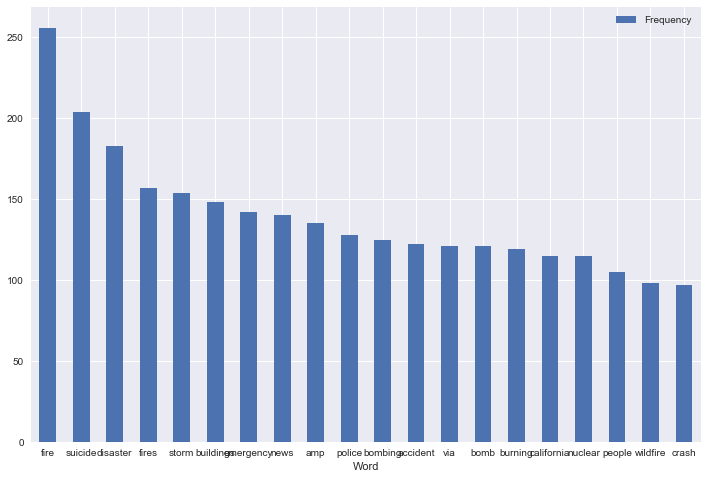

In [25]:
ht_disaster_df = show_word_distrib(target=1, field='text (cleaned)')

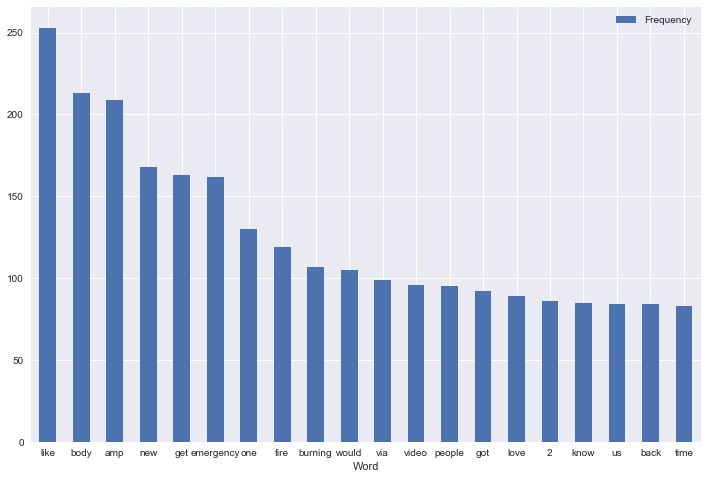

In [26]:
ht_nondisaster_df = show_word_distrib(target=0, field='text (cleaned)')

In [27]:
set(ht_nondisaster_df.index).intersection(ht_disaster_df.index) 

{'amp', 'burning', 'emergency', 'fire', 'people', 'via'}

There are still some intersections.  Maybe these words/numbers should be excluded from the models.

## Models

Let's train some models.

In [28]:
def add_meta_features(df):
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split(' ')))
    df['unique_word_count'] = df['text'].apply(lambda x: len(set(str(x).split(' '))))
    df['stop_word_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split(' ') if w in stopwords]))
    df['url_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split(' ') if 'http' in w or 'https' in w]))
    df['mean_word_length'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split(' ')]))
    df['char_count'] = df['text'].apply(lambda x: len(str(x)))
    df['punctuation_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    df['mention_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
    df['hashtag_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

In [29]:
add_meta_features(train_df)
add_meta_features(test_df)

meta_columns = [c for c in train_df.columns if '_count' in c or '_length' in c]

In [30]:
# Combine the text and meta features.
def combine_features(X, df):
    for col in meta_columns:
        X = hstack((X, df[col].values[:, None]))
        
    return X

In [31]:
tfidf = TfidfVectorizer(
    sublinear_tf=True,
    ngram_range=(1,3),
    norm='l2',
    min_df=5
)

# Fit on both the train and test set.
tfidf.fit(train_df['text (cleaned)'].append(test_df['text (cleaned)']))

X = tfidf.transform(train_df['text (cleaned)'])

C:\Users\Craig\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [32]:
tfidf.get_feature_names()

['010401',
 '010401 utc20150805',
 '010401 utc20150805 150401',
 '02',
 '05',
 '06',
 '10',
 '100',
 '1000',
 '101',
 '101 cook',
 '101 cook re',
 '1030',
 '1030 pm',
 '10th',
 '11',
 '11yearold',
 '11yearold boy',
 '11yearold boy charged',
 '12',
 '12 72w',
 '12 72w cree',
 '12000',
 '12000 nigerian',
 '12000 nigerian refugees',
 '13',
 '13 reasons',
 '13 reasons love',
 '13 saudi',
 '13 saudi mosque',
 '13000',
 '14',
 '14 lez',
 '14 lez compliant',
 '15',
 '15 saudi',
 '15 saudi security',
 '150',
 '150401',
 '150401 1000',
 '16',
 '16yr',
 '16yr old',
 '16yr old pkk',
 '17',
 '1716',
 '1716 st',
 '1716 st nw',
 '18',
 '18w',
 '18w cree',
 '18w cree led',
 '19',
 '19 5km',
 '19 5km volcano',
 '1945',
 '1980',
 '1st',
 '20',
 '20 amp',
 '20 amp mod',
 '200',
 '2008',
 '2009',
 '2011',
 '2013',
 '2013 property',
 '2013 property sat',
 '2014',
 '2015',
 '2015 australia',
 '2016',
 '20accident',
 '20bag',
 '20bagging',
 '20bags',
 '20bang',
 '20bomb',
 '20bomber',
 '20bomber suicide',
 

In [33]:
X = combine_features(X, train_df)

X_train, X_test, y_train, y_test = train_test_split(X, train_df['target'], test_size=0.20, random_state=0)

In [34]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

In [35]:
f1_score(y_test, y_pred)

0.7491525423728814

In [36]:
confusion_matrix(y_test, y_pred)

array([[785, 101],
       [195, 442]], dtype=int64)

In [37]:
X_pred = tfidf.transform(test_df['text (cleaned)'])
X_pred = combine_features(X_pred, test_df)

y_submission = lr.predict(X_pred)

C:\Users\Craig\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [38]:
submission_df = pd.DataFrame([], columns=[])

submission_df['id'] = test_df['id']
submission_df['target'] = y_submission

submission_df.to_csv('./submission_lr.csv', index=False)

In [39]:
start_time = time.time()

xgb = xgboost.XGBClassifier(
    seed=0,
    n_estimators=500
)
xgb.fit(X_train, 
        y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True,
        early_stopping_rounds=10
)

time.time() - start_time

[0]	validation_0-error:0.358456	validation_1-error:0.362443
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.341544	validation_1-error:0.341431
[2]	validation_0-error:0.333662	validation_1-error:0.344714
[3]	validation_0-error:0.335796	validation_1-error:0.340118
[4]	validation_0-error:0.334319	validation_1-error:0.344058
[5]	validation_0-error:0.330378	validation_1-error:0.341431
[6]	validation_0-error:0.327094	validation_1-error:0.340118
[7]	validation_0-error:0.323317	validation_1-error:0.338805
[8]	validation_0-error:0.319376	validation_1-error:0.335522
[9]	validation_0-error:0.3133	validation_1-error:0.347341
[10]	validation_0-error:0.312644	validation_1-error:0.344714
[11]	validation_0-error:0.311166	validation_1-error:0.340118
[12]	validation_0-error:0.311823	validation_1-error:0.342745
[13]	validation_0-error:0.310837	validation_1-error:0.3407

[132]	validation_0-error:0.22069	validation_1-error:0.2587
[133]	validation_0-error:0.22069	validation_1-error:0.258043
[134]	validation_0-error:0.22069	validation_1-error:0.258043
[135]	validation_0-error:0.21954	validation_1-error:0.25673
[136]	validation_0-error:0.219212	validation_1-error:0.25673
[137]	validation_0-error:0.218555	validation_1-error:0.255417
Stopping. Best iteration:
[127]	validation_0-error:0.222332	validation_1-error:0.255417



13.805114507675171

In [40]:
confusion_matrix(y_test, xgb.predict(X_test))

C:\Users\Craig\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[755, 131],
       [258, 379]], dtype=int64)

In [41]:
y_submission = xgb.predict(X_pred)

submission_df = pd.DataFrame([], columns=[])

submission_df['id'] = test_df['id']
submission_df['target'] = y_submission

submission_df.to_csv('./submission_xgb.csv', index=False)

C:\Users\Craig\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
